In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import time

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CIC-PDFMal2022\\PDFMalware2022.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10026 entries, 0 to 10025
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fine name         10026 non-null  object 
 1   pdfsize           10025 non-null  float64
 2   metadata size     10025 non-null  float64
 3   pages             10025 non-null  float64
 4   xref Length       10025 non-null  float64
 5   title characters  10025 non-null  float64
 6   isEncrypted       10025 non-null  float64
 7   embedded files    10025 non-null  float64
 8   images            10025 non-null  object 
 9   text              10025 non-null  object 
 10  header            10025 non-null  object 
 11  obj               10023 non-null  object 
 12  endobj            10023 non-null  object 
 13  stream            10023 non-null  float64
 14  endstream         10023 non-null  object 
 15  xref              10023 non-null  object 
 16  trailer           10023 non-null  float6

In [4]:
#Feature Selection
features_to_drop = ['Fine name', 'images', 'text', 'header', 'obj', 'endobj', 'endstream', 
                    'xref', 'startxref', 'pageno', 'JS', 'Javascript', 'AA', 'OpenAction', 
                    'Acroform', 'JBIG2Decode', 'RichMedia', 'launch', 'EmbeddedFile', 'XFA', 'Class']

# Droping specified columns and target variable
X = DM.drop(features_to_drop, axis=1).values    
y = DM['Class'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
# Applying Min-Max scaling to make X non-negative
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Random Forest Feature Importance - Embedded
rf_model = RandomForestClassifier().fit(X_scaled, y)
rf_importances = rf_model.feature_importances_

In [8]:
# Select top 5 features based on Random Forest importance
rf_top_features = np.argsort(rf_importances)[::-1][:5]

# Mengambil nama kolom dari X yang sudah difilter
filtered_columns = DM.drop(features_to_drop, axis=1).columns

features = []
for idx in rf_top_features:
    print(f"Feature {filtered_columns[idx]} dengan skor Random Forest {rf_importances[idx]}")
    features.append(filtered_columns[idx])

Feature metadata size dengan skor Random Forest 0.26480441978378433
Feature stream dengan skor Random Forest 0.19602707575148667
Feature pdfsize dengan skor Random Forest 0.1556796379795719
Feature xref Length dengan skor Random Forest 0.13566541880151728
Feature trailer dengan skor Random Forest 0.09967213427789777


In [9]:
# Memilih 100% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
hasil_threshold = []

In [10]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malicious"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Random Forest.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Random Forest.csv'")

Progress: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [3:26:43<00:00, 2480.74s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Hasil threshold disimpan ke dalam file 'Random Forest.csv'


In [11]:
HasilThreshold = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\01-10-2024\\Random Forest.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365856 entries, 0 to 365855
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Feature       365856 non-null  object 
 1   Threshold     365856 non-null  int64  
 2   Precision     365856 non-null  float64
 3   Recall        365856 non-null  float64
 4   F1_Score      365856 non-null  float64
 5   Accuracy      365856 non-null  float64
 6   Elapsed_Time  365856 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 19.5+ MB


In [12]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [13]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

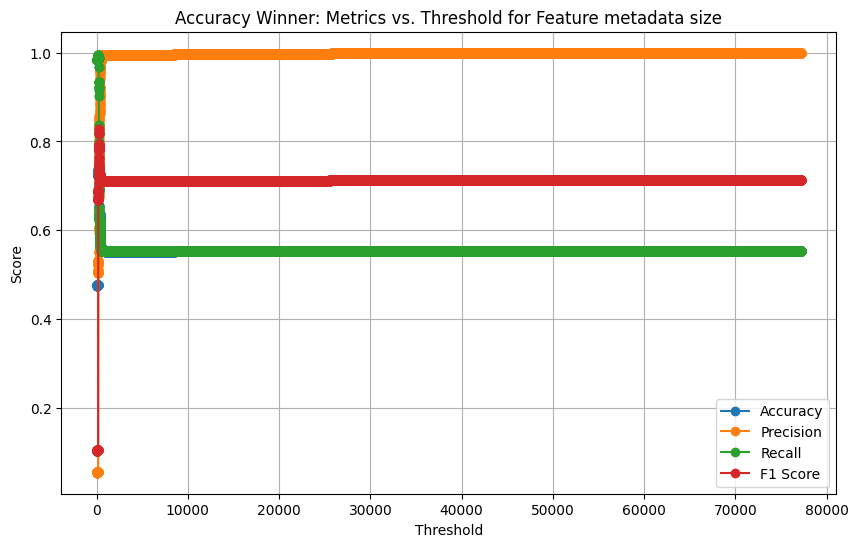

In [15]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

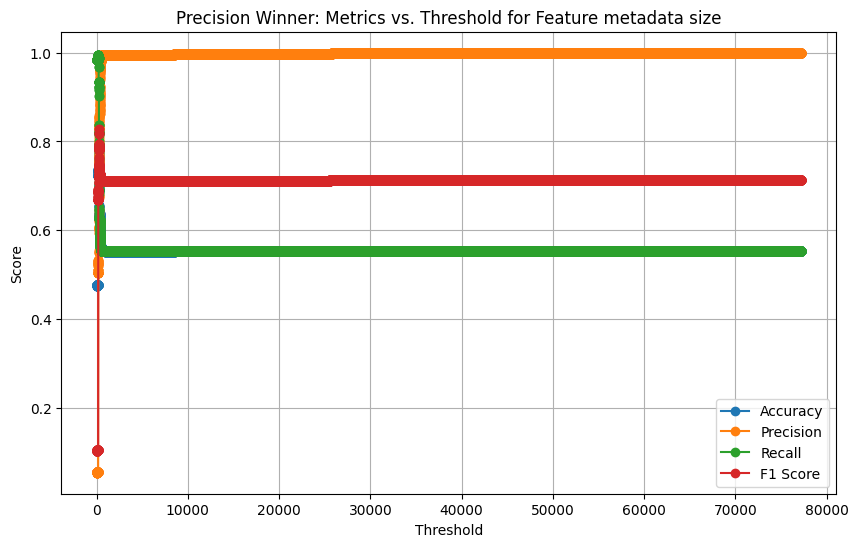

In [16]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

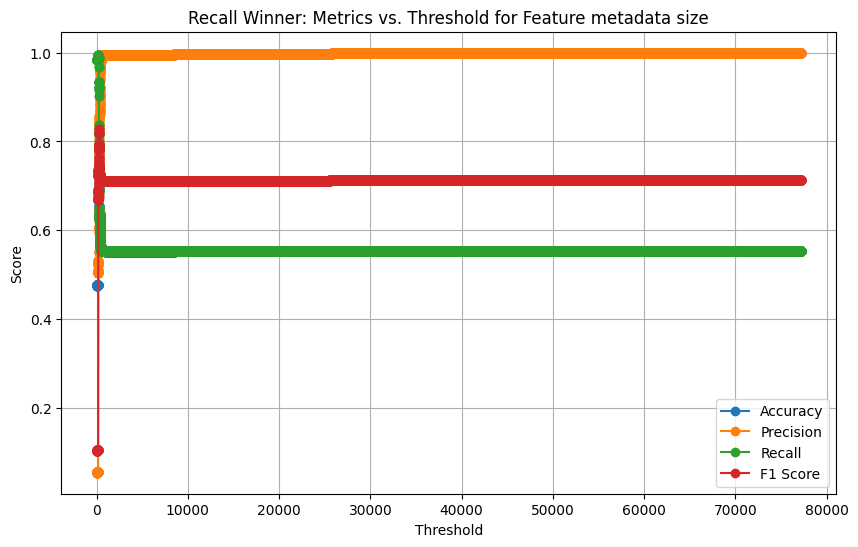

In [17]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

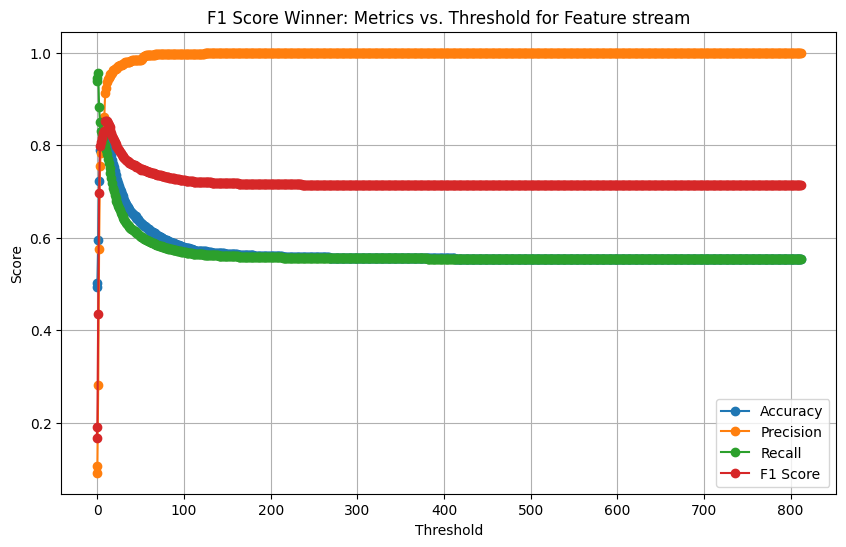

In [18]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

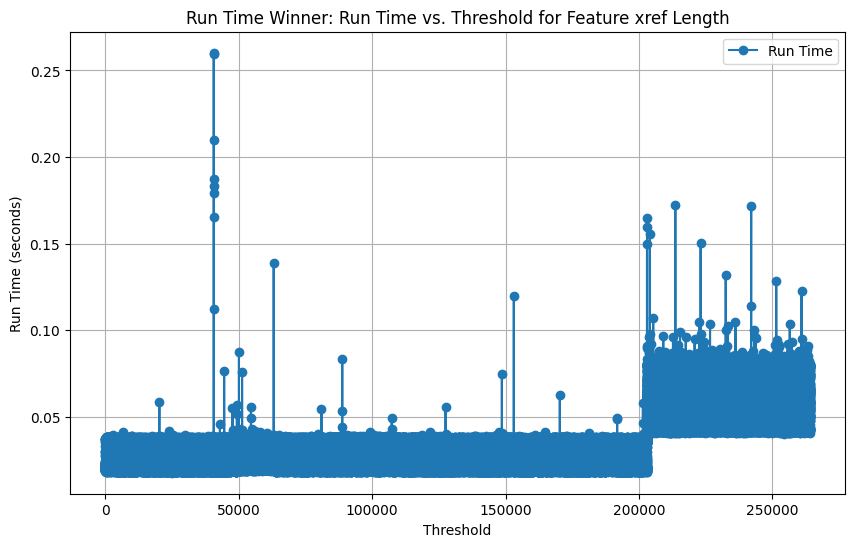

In [19]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [20]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur metadata size dan threshold 77185, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur metadata size dan threshold 189, menghasilkan recall 0.994314143567875.
F1-score terbaik dicapai dengan fitur stream dan threshold 9, menghasilkan F1-score 0.8530821629804054.
Akurasi terbaik dicapai dengan fitur metadata size dan threshold 259, menghasilkan akurasi 0.8270324189526185.
Waktu running tercepat dicapai dengan fitur xref Length dan threshold 24985, dengan waktu running 0.0176410675048828 detik.
